<a href="https://colab.research.google.com/github/kasev/PIA/blob/master/scripts/OVERVIEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re

import nltk
from nltk.collocations import *

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.colab import auth
from oauth2client.client import GoogleCredentials

!pip install sddk
import sddk

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#!pip install anda
#from anda import gr ### the import takes substantial time, since it import a +600MB file containing ancient Greek dictionary

     |████████████████████████████████| 21.3MB 1.4MB/s 


In [2]:
### not neccessary for reading the data, just for exporting them to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [3]:
### authorize google sheets
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
# establish connection with particular sheet by its url:

PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

In [7]:
### our data are located within a publicly available folder on sciencedata.dk
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_aristotelicum = sddk.read_file("c_aristotelicum_repl.json", "df", publicfolder)
c_hippocraticum = sddk.read_file("c_hippocraticum_repl.json", "df", publicfolder)

this file is located in a public folder
this file is located in a public folder


In [8]:
# patterns used in the replacement
keyterm_patterns = [("^λ[υ|ύ]π.+", "λύπ*"), ("^[ἀ|ἄ]λγ.+", "ἄλγ*"), ("^[ὀ|ὠ]δ[ύ|υ]ν.", "ὀδύν*"), ("^π[ό|ο]ν[ο|ό|έ|ε|η|ή|ῆ](?!ρ).+", "πόνο*")]

In [9]:
# make overview columns of individual terms accross documents
for pattern_tuple in keyterm_patterns:
  term = pattern_tuple[1] # eg. "λύπ*"
  c_aristotelicum[term] =  c_aristotelicum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)
  c_hippocraticum[term] =  c_hippocraticum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)

In [10]:
c_aristotelicum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*     391
ἄλγ*      32
ὀδύν*      3
πόνο*    100
dtype: int64

In [11]:
c_hippocraticum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*      58
ἄλγ*     315
ὀδύν*    642
πόνο*    651
dtype: int64

In [12]:
# what columns we have
# (which columns to drop while exporting to gsheet - "string" etc. contain large data)
print(list(c_aristotelicum.columns))

['filename', 'author', 'title', 'string', 'author_id', 'doc_id', 'raw_date', 'date_avr', 'date_probs', 'date_manual', 'provenience', 'wordcount', 'lemmata', 'lemmatized_sentences', 'lemmata_wordcount', 'num_of_sents', 'lemmata_repl', 'lemmatized_sentences_repl', 'λύπ*', 'ἄλγ*', 'ὀδύν*', 'πόνο*']


In [ ]:
# uncomment to export overview data to gsheet
# set_with_dataframe(PIA_overview.add_worksheet("c_aristotelicum_20200814",1,1), c_aristotelicum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))
# set_with_dataframe(PIA_overview.add_worksheet("c_hippocraticum_20200814",1,1), c_hippocraticum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))

In [21]:
for term in ["λύπ*", "ἄλγ*", "ὀδύν*",	"πόνο*"]:
  c_aristotelicum[term + "_weighted"] = c_aristotelicum.apply(lambda row: row[term] / row["wordcount"], axis=1)
  c_hippocraticum[term + "_weighted"] = c_hippocraticum.apply(lambda row: row[term] / row["wordcount"], axis=1)
c_aristotelicum["weighted_sum"] = c_aristotelicum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], axis=1)
c_hippocraticum["weighted_sum"] = c_hippocraticum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], axis=1)

In [61]:
c_aristotelicum

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmatized_sentences,lemmata_wordcount,num_of_sents,lemmata_repl,lemmatized_sentences_repl,λύπ*,ἄλγ*,ὀδύν*,πόνο*,λύπ*_weighted,ἄλγ*_weighted,ὀδύν*_weighted,πόνο*_weighted,weighted_sum
678,tlg0086.tlg001.1st1K-grc2.xml,Aristotle,Aristotelis Analytica Priora et Posteriora; Ar...,ΑΝΑΛΥΤΙΚΩΝ ΠΡΟΤΕΡΩΝ Α. Πρῶτον εἰπεῖν περὶ τί κ...,tlg0086,tlg0086.tlg001,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,59772,"[αναλυτικων, πρότερος, πρότερος, εἶπον, σκέψις...","[[αναλυτικων, πρότερος], [πρότερος, εἶπον, σκέ...",21150,3645,"[αναλυτικων, πρότερος, πρότερος, εἶπον, σκέψις...","[[αναλυτικων, πρότερος], [πρότερος, εἶπον, σκέ...",0,1,0,0,0.000000,0.000017,0.000000,0.000000,0.000017
679,tlg0086.tlg002.1st1K-grc2.xml,Aristotle,De anima; Aritoteles De anima,ΠEP1 ΨΥΧΗΣ Α Τῶν καλῶν καὶ τιμίων τὴν εἴδησιν ...,tlg0086,tlg0086.tlg002,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,20988,"[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ἕ...","[[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ...",8893,1306,"[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ἕ...","[[ψυχή, κᾶλον, τίμιος, εἶδος, μαλλός, ἕτερος, ...",12,0,0,0,0.000572,0.000000,0.000000,0.000000,0.000572
681,tlg0086.tlg005.1st1K-grc1.xml,Aristotle,De caelo; Aristoteles De coelo et De generatio...,ΠEPI ΟΥΡΑΝΟΥ A. Ἡ περὶ φύσεως ἐπιστήμη σχεδὸν ...,tlg0086,tlg0086.tlg005,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,31395,"[οὐρανός, φύσις, ἐπιστήμη, πλεῖστος, φαίνω, σῶ...","[[οὐρανός], [φύσις, ἐπιστήμη, πλεῖστος, φαίνω,...",12915,1986,"[οὐρανός, φύσις, ἐπιστήμη, πλεῖστος, φαίνω, σῶ...","[[οὐρανός], [φύσις, ἐπιστήμη, πλεῖστος, φαίνω,...",0,0,0,1,0.000000,0.000000,0.000000,0.000032,0.000032
682,tlg0086.tlg006.1st1K-grc1.xml,Aristotle,Categoriae; Aristotelis Opera,ΚΑΤΗΓΟΡΙΑΙ. ὉΜΩΝΥΜΑ λέγεται ὧν ὄνομα μόνον κοι...,tlg0086,tlg0086.tlg006,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,10317,"[κατηγορία, ὁμωνυμα, λέγω, ὄνομα, μόνος, κοινό...","[[κατηγορία], [ὁμωνυμα, λέγω, ὄνομα, μόνος, κο...",4372,659,"[κατηγορία, ὁμωνυμα, λέγω, ὄνομα, μόνος, κοινό...","[[κατηγορία], [ὁμωνυμα, λέγω, ὄνομα, μόνος, κο...",2,0,0,0,0.000194,0.000000,0.000000,0.000000,0.000194
683,tlg0086.tlg008.1st1K-grc1.xml,Aristotle,De divinatione per somnum; Aristotelis Opera,ΠΕΡΙ ΕΝΥΠΝΙΩΝ ΚΑΙ ΤΗΣ ΚΑΘ’ ΥΠΝΟΝ ΜΑΝΤΙΚΗΣ. Περ...,tlg0086,tlg0086.tlg008,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,1207,"[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός, μαντικ...","[[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός], [μαν...",533,69,"[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός, μαντικ...","[[ἐνύπνιον, ἀκή, ἄατος, ὕπνος, μαντικός], [μαν...",0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
684,tlg0086.tlg009.perseus-grc1.xml,Aristotle,Eudemian Ethics (Greek). Machine readable text...,ὁ μὲν ἐν Δήλῳ παρὰ τῷ θεῷ τὴν αὑτοῦ γνώμην ἀπο...,tlg0086,tlg0086.tlg009,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,26361,"[δῆλος, θεός, γνώμη, συγγράφω, προπύλαιος, Λητ...","[[δῆλος, θεός, γνώμη, συγγράφω, προπύλαιος, Λη...",11158,1676,"[δῆλος, θεός, γνώμη, συγγράφω, προπύλαιος, Λητ...","[[δῆλος, θεός, γνώμη, συγγράφω, προπύλαιος, Λη...",72,3,1,7,0.002731,0.000114,0.000038,0.000266,0.003149
685,tlg0086.tlg010.perseus-grc1.xml,Aristotle,Nicomachean Ethics; Machine readable text; ed....,"βοοκ 1 πᾶσα τέχνη καὶ πᾶσα μέθοδος, ὁμοίως δὲ ...",tlg0086,tlg0086.tlg010,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,56638,"[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξί...","[[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξ...",23811,3897,"[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξί...","[[βοοκ, πᾶς, τέχνη, πᾶς, μέθοδος, ὅμοιος, πρᾶξ...",148,6,0,11,0.002613,0.000106,0.000000,0.000194,0.002913
687,tlg0086.tlg014.1st1K-grc1.xml,Aristotle,Historia animalium; Aristotelis Opera,ΠΕΡΙ ΤΑ ΖΩΙΑ ΙΣΤΟΡΙΩΝ Α. ΤΩΝ ἐν τοῖς ζῴοις μορ...,tlg0086,tlg0086.tlg014,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,94068,"[ζωια, ἱστορία, ζῷον, μορία, ἀσύνθετος, ὅσος, ...","[[ζωια, ἱστορία], [ζῷον, μορία, ἀσύνθετος, ὅσο...",43435,6345,"[ζωια, ἱστορία, ζῷον, μορία, ἀσύνθετος, ὅσος, ...","[[ζωια, ἱστορία]

In [38]:
c_aristotelicum["λύπ*_weighted"].max()

0.0027313076135199728

In [52]:
plt.get_cmap('Greens')

'Economics (Greek). Machine readable text; Aristotle in 23 Volumes, Vol. 18'

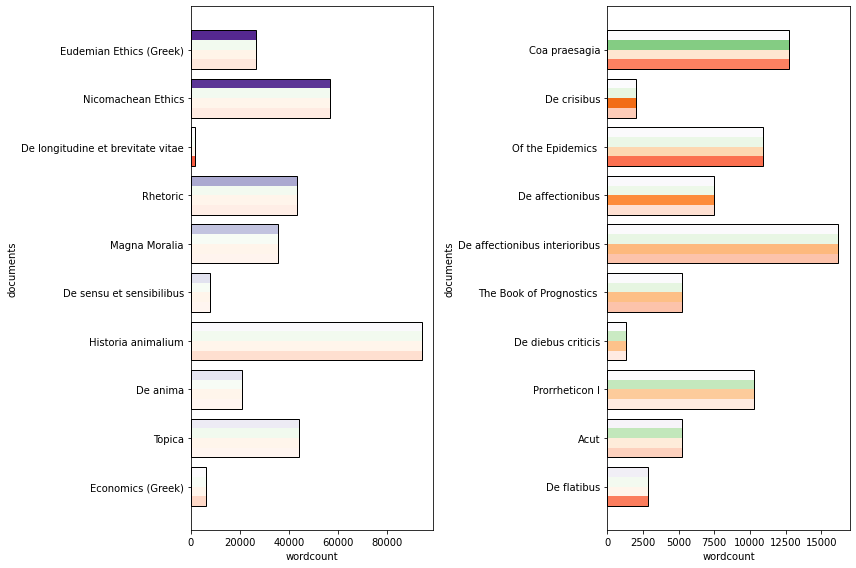

In [95]:
import matplotlib
import matplotlib.pyplot as plt

# preprocess the two datasets
c_aristotelicum_10 = c_aristotelicum.sort_values("weighted_sum", ascending=False)[:10][::-1]
c_hippocraticum_10 = c_hippocraticum.sort_values("weighted_sum", ascending=False)[:10][::-1]

# preproducing the figure object
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 8), tight_layout=True)

# CORPUS ARISTOTELICUM
labels = [title.partition(";")[0].partition(".")[0] for title in c_aristotelicum_10["title"].tolist()]
wordcounts = c_aristotelicum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"),	("πόνο*", "Reds")]:
  coloring = c_aristotelicum_10[keyterm + "_weighted"] / c_aristotelicum_10["weighted_sum"].max()
  ax1.barh(y + 0.3 - bar_location, wordcounts, width, color=plt.get_cmap(colormap)(coloring), label=keyterm)
  bar_location = bar_location + 0.2
ax1.barh(y, wordcounts, width * 4, color="none", edgecolor="black")
#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel("wordcount")
ax1.set_ylabel("documents")
ax1.set_yticks(y)
ax1.set_yticklabels(labels)
# ax.legend()

# CORPUS HIPPOCRATICUM
labels = [title.partition(";")[0].partition(".")[0] for title in c_hippocraticum_10["title"].tolist()]
wordcounts = c_hippocraticum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"),	("πόνο*", "Reds")]:
  coloring = c_hippocraticum_10[keyterm + "_weighted"] / c_hippocraticum_10["weighted_sum"].max()
  ax2.barh(y + 0.3 - bar_location, wordcounts, width, color=plt.get_cmap(colormap)(coloring), label=keyterm)
  bar_location = bar_location + 0.2
ax2.barh(y, wordcounts, width * 4, color="none", edgecolor="black")


#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xlabel("wordcount")
ax2.set_ylabel("documents")
ax2.set_yticks(y)
ax2.set_yticklabels(labels)
# ax.legend()

#plt.colorbar(im, cmap=plt.set_cmap("Greens"))#autolabel(rects1)

fig.tight_layout()

plt.show()

In [103]:
for n in range(10):
  print(n)

0
1
2
3
4
5
6
7
8
9


In [118]:
sizes = [val / c_aristotelicum_10.iloc[9]["weighted_sum"] * 100 for val in  c_aristotelicum_10.iloc[9][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()]
sizes

[86.74698795180723, 3.614457831325301, 1.2048192771084338, 8.433734939759036]

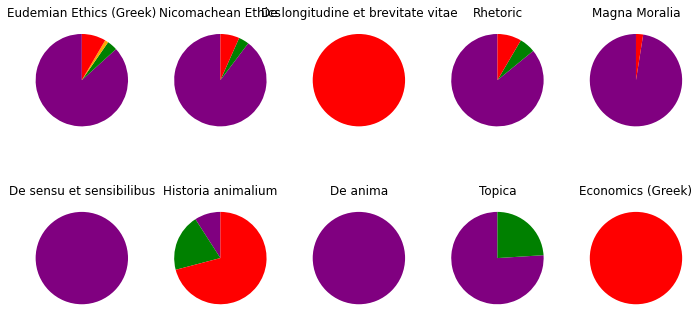

In [127]:
# PIE CHART (OF THE SAME DATA)

c_aristotelicum_10.sort_values("weighted_sum", ascending=False, inplace=True)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [title.partition(";")[0].partition(".")[0] for title in c_aristotelicum_10["title"].tolist()]

fig, axs  = plt.subplots(2, 5, figsize=(12,6))

for ax, n, label in zip(axs.ravel(), range(10), labels):
  sizes = [val / c_aristotelicum_10.iloc[n]["weighted_sum"] * 100 for val in  c_aristotelicum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()]
  ax.pie(sizes, colors=["purple", "green", "orange", "red"], startangle=90)
  ax.set_title(label)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()